In [37]:
import numpy as np

def forcing_to_conc(RF_in, 
                   RF_ext = None, 
                   RF_ext_in = False,
                   param_array = np.array([5.396,278.])):
    
   # --- PARAMETERS ---
    #param_array,
        # 1) a = logarithmic forcing efficacy in W/m-2/alog(2). Default = 5.396 W/m^2
        # 2) Cpreind = preindustrial CO2 concentration in ppmv (278.)
    # RF_ext = external radaitive forcing profile which contributes but shouldn't add to the equivalent CO2 concentrations
    # RE_ext_in = boolean, allows user to include or not include the contribution to RF of other (non-anthropogenic) sources
   #---  ----  ---  ---
    
   #Initializing parameters
    a = param_array[...,0]
    C_preind = param_array[...,1]
    if RF_in.ndim == 1:
        rf_dim = 1
        RF_in = RF_in[np.newaxis]
    else:
        rf_dim = RF_in.shape[0]
    
   # Initializing arrays
    # Create array to hold concentration values
    C = np.zeros((RF_in.shape[0],a.size, RF_in.shape[-1]))
    
    # Check inputs are of the same size if external forcing data is also provided
    if RF_ext_in == True:
        if RF_in.shape != RF_ext.shape:
            print 'The inputs RF_in and RF_ext are not of the same shape!'
    elif RF_ext_in == False:
        RF_ext = np.zeros(RF_in.shape)
    
   # Compute required co2 concentration to produce inputted logarithmic forcing
    for i in range(0, RF_in.shape[-1]):
        C[...,i]=np.exp((RF_in[:,np.newaxis,i]-RF_ext[:,np.newaxis,i])/a)*C_preind
    
    return C

In [2]:
from scipy.optimize import root
import scipy.ndimage.filters as filters1

def iirf100_interp_funct(alpha,a,tau,targ_iirf100):
    iirf100_arr = alpha*(np.sum(a*tau*(1.0 - np.exp(-100.0/(tau*alpha)))))
    return iirf100_arr   -  targ_iirf100

def conc_to_emissions_multiparam(co2_conc, T_input, 
                      tstep = 1.0,
                      year_smoothing = 5,
                      param_array = np.array([1000000,381.330,34.7850,4.12370,0.21787,0.22896,0.28454,0.26863,0.471,32.40,0.019,4.165,97.,278.,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
                      ):
    if param_array.ndim < 2:
        param_array = param_array[np.newaxis]
    
   #initialize parameters
    t_const = param_array[...,0:4]
    pool_splits = param_array[...,4:8]
    GtC_2_ppmv = param_array[...,8]
    r0=param_array[...,9]
    rC=param_array[...,10]
    rT=param_array[...,11]
    iirf100_max = param_array[...,12]
    Cpreind = param_array[...,13]
    R_i_in=param_array[...,14:18]
    T_j_in=param_array[...,18:20]
    in_state_other = param_array[...,20]
    
   # PARAMETERS #
    # co2_conc = inputted co2 forcing equivalent concentration profile
    # T_input = inputted temperature profile for given concentration profile
    # t_const = time constants for the different carbon pools
    # pool_splits = how a unit mass of carbon is split between the pools
    # r0 = 100-year integrated airborne fraction (iIRF100) in the initial equilibrium climate for an infinintesimal pulse
    # rC = sensitivity of iIRF100 to cumulative land-ocean carbon uptake, in years/GtC
    # rT = temperature sensitivity of iIRF100 in years/K
    # iirf100_max = maximum value of the iIRF100 we can calculate (saturates at this value if found to be above)
    # Cpreind = pre-industrial CO2 concentration
    # tstep = timestep between interations of code. Default = 1 yr, never tried for other
    # in_state = input state of the different vectors being calcualted
     
   #initialize the carbon pools, emissions, accumulated carbon and iIRF100 vectors. 
    #Give an intial guess of alpha for root function to work from.
    integ_len = co2_conc.shape[-1]
    num_forc = co2_conc.shape[0]
    num_param = co2_conc.shape[1]
    
    C_comp = np.zeros((num_forc, num_param, integ_len, 4))
    E = np.zeros((num_forc, num_param, integ_len))
    C_acc = np.zeros((num_forc, num_param, integ_len))
    iirf100 = np.zeros((num_forc, num_param, integ_len))
    alph_t_start = 0.16
    alph_t = np.zeros((num_forc,num_param))
    
    if num_param < 1:
        t_const = param_array[np.newaxis]
        pool_splits = param_array[np.newaxis]
        GtC_2_ppmv = param_array[np.newaxis]
        r0=param_array[np.newaxis]
        rC=param_array[np.newaxis]
        rT=param_array[np.newaxis]
        iirf100_max = param_array[np.newaxis]
        Cpreind = param_array[np.newaxis]
        R_i_in=param_array[np.newaxis]
        T_j_in=param_array[np.newaxis]
        in_state_other = param_array[np.newaxis]
        C_comp = C_comp[:, np.newaxis, ...]
        E = E[:, np.newaxis, :]
        C_acc = C_acc[:, np.newaxis, :]
        iirf100 = iirf100[:, np.newaxis, :]
        alph_t_start = 0.16
        alph_t = alph_t[:,np.newaxis]
    
   ###---------FIRST TIMESTEP----------
    #set the initial values of key parameters as the in_state values, default = zeros.
    C_comp_pre = R_i_in
    C_pre = np.sum(C_comp_pre, axis = -1) + Cpreind
    T_j_pre = T_j_in
    C_acc_pre = in_state_other

    # Calculate the parametrised iIRF100 and check if it is over the maximum allowed value
    for i in range(0,num_forc):
        for j in range(0, num_param):
            iirf100[i,j,0] = r0[j] + rC[j]*C_acc[i,j,0] + rT[j]*T_input[i,j,0]
            if iirf100[i,j,0] >= iirf100_max[j]:
                iirf100[i,j,0] = iirf100_max[j]
    
    #find the value of alpha
    for i in range(0,num_forc):
        for j in range(0,num_param):
            alph_t[i,j] = (root(iirf100_interp_funct,alph_t_start,args=(pool_splits[j,:],t_const[j,:],iirf100[i,j,0])))['x']
    
            #compute the carbon in each pool
            C_comp[i,j,0,:] = C_comp_pre[j,:]*np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))
    
            #compute the emissions required to give change in CO2 concentration
            E[i,j,0] = (co2_conc[i,j,0] - np.sum(C_comp[i,j,0,:],-1) - C_pre[j]) / (alph_t[i,j]*np.sum(pool_splits[j,:]*t_const[j,:]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))))*GtC_2_ppmv[j])
    
            #recompute the distribution of carbon in each pool for better estimation of emissions in next timestep
            C_comp[i,j,0,:] = C_comp[i,j,0,:] + alph_t[i,j]*pool_splits[j,:]*t_const[j,:]*E[i,j,0]*GtC_2_ppmv[j]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:])))
    
            #calculate the accumulated carbon in the land and oceans
            C_acc[i,j,0] =  C_acc_pre[j] + E[i,j,0]*tstep - ((co2_conc[i,j,0]-C_pre[j])/GtC_2_ppmv[j])
    
   ###----------REST OF RUN-------------
    for i in range(0,num_forc):
        for j in range(0,num_param):
            for k in range(1, integ_len):
                #estimate the value of iIRF100, given the temperature and accumulated carbon in previous timestep
                iirf100[i,j,k] = r0[j] + rC[j]*C_acc[i,j,k-1] + rT[j]*T_input[i,j,k-1]
                if iirf100[i,j,k] > iirf100_max[j]:
                    iirf100[i,j,k] = iirf100_max[j]
        
                #calculate the value of alpha using scipys root finder
                alph_t[i,j] = (root(iirf100_interp_funct,alph_t[i,j],args=(pool_splits[j,:],t_const[j,:],iirf100[i,j,k])))['x']
        
                #compute the distribution of carbon between the pools
                C_comp[i,j,k,:] = C_comp[i,j,k-1,:]*np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))
        
                #calculate the emissions required in this year to cause change in CO2 concentration
                E[i,j,k] = (co2_conc[i,j,k] - np.sum(C_comp[i,j,k,:],-1) - Cpreind[j]) / (alph_t[i,j]*np.sum(pool_splits[j,:]*t_const[j,:]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:]))))*GtC_2_ppmv[j])
        
                #recalculate the distribution of carbon in each pool for better estimation in next timestep
                C_comp[i,j,k,:] = C_comp[i,j,k,:] + \
                    alph_t[i,j]*pool_splits[j,:]*t_const[j,:]*E[i,j,k]*GtC_2_ppmv[j]*(1-np.exp((-tstep)/(alph_t[i,j]*t_const[j,:])))
        
                #calculate the accumulated carbon in the land and sea
                C_acc[i,j,k] =  C_acc[i,j,k-1] + E[i,j,k]*tstep - ((co2_conc[i,j,k]-co2_conc[i,j,k-1])/GtC_2_ppmv[j])
        
   ###----------------------------------
   
    # We apply a gaussian filter to smooth the resulting curve
    E_smooth = np.zeros((num_forc,num_param,integ_len))
    for i in range(0,num_forc):
        for j in range(0,num_param):
            E_smooth[i,j,:] = filters1.gaussian_filter1d(E[i,j,:], year_smoothing)
    
    return E, E_smooth

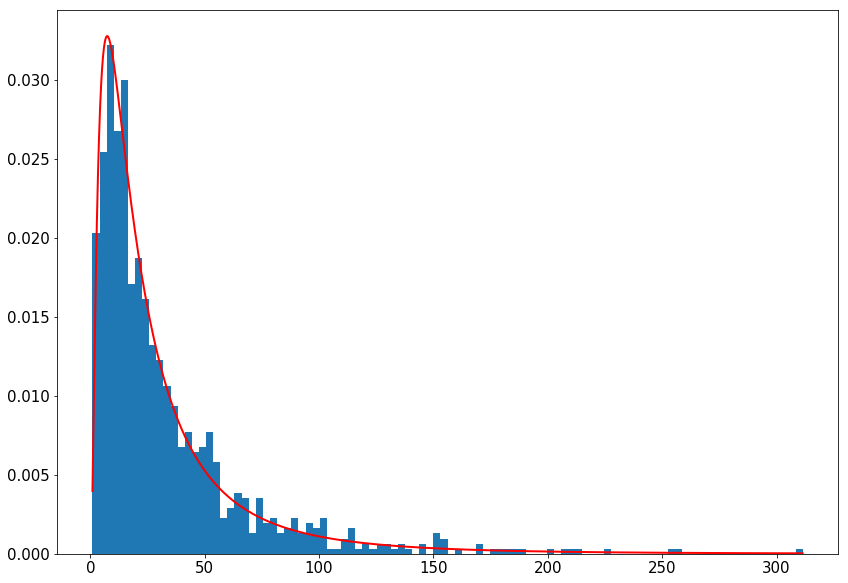

In [3]:
#importing anthro_rf profiles
rf_anthro_piers = np.loadtxt("rf_a_reord.txt")
rf_anthro_piers = rf_anthro_piers.reshape((200,267))
rf_90 = rf_anthro_piers[90,:]

#---- Creating parameter distributions ----#
# a0,a1,a2,a3
# tcr - log-normal distribution (5-95% region 1.0-2.5 K)
# RWF - bounded (0-1) gaussian, 5-95% region 0.45-0.75
# ecs distribution found by taking the convolution of the RWF and tcr distributions
#

# 1) TCR distribution

mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)

#------------
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 10
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 15}

plt.rc('font', **font)
#-------------


count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()


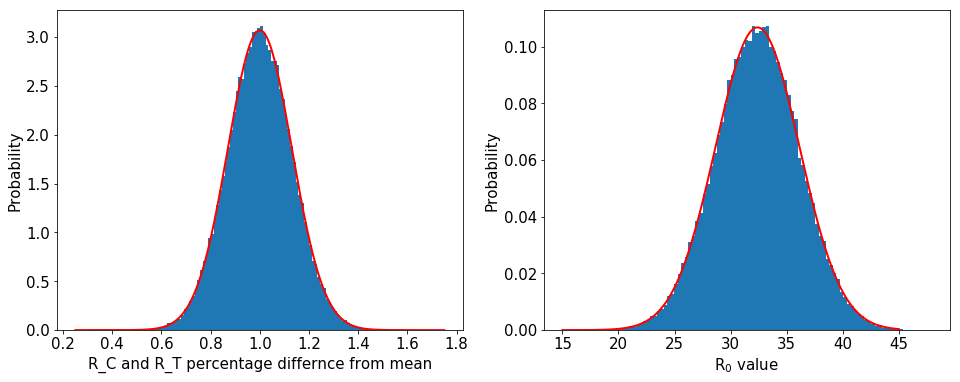

In [161]:
from random import randint
from scipy.stats import lognorm

#lognormal distribution for TCR

#mu_TCR, sigma_TCR = np.log(1.6), 0.284054 # mean and standard deviation
#x_TCR = np.linspace(0.00004, 4, 99999)
#pdf_TCR = (np.exp(-(np.log(x_TCR) - mu_TCR)**2 / (2 * sigma_TCR**2)) / (x_TCR * sigma_TCR * np.sqrt(2 * np.pi)))
f1 = plt.figure(figsize = (16,20))
#ax11 = f1.add_subplot(321)
#ax11.hist(np.random.lognormal(mean = np.log(1.6), sigma = 0.284054, size = (100000)).tolist(), bins = 100, normed = True)
#ax11.plot(x_TCR, pdf_TCR, linewidth=2, color='r')
#ax11.set_xlabel('TCR value')
#ax11.set_ylabel('Probability')

#gaussian distribution of RWF (bounded between 0 and 1, 5-95% = 0.45-0.75)

#mu_RWF, sigma_RWF = 0.53107507196960269, 0.13309690567187238
#x_RWF = np.linspace(0.001, 1, 99999)
#pdf_RWF = np.exp(-(x_RWF - mu_RWF)**2 / (2 * sigma_RWF**2)) / (sigma_RWF * np.sqrt(2 * np.pi))
#ax22 = f1.add_subplot(322)
#ax22.hist(np.random.normal(loc = 0.53107507196960269, scale = 0.13309690567187238, size = (100000)).tolist(), bins = 100, normed = True)
#ax22.plot(x_RWF, pdf_RWF, linewidth=2, color='r')
#ax22.set_xlabel('RWF value')
#ax22.set_ylabel('Probability')

#-------------

# inferred distribution of ECS

ECS_val = np.zeros(100000)
for i in range(0,ECS_val.size):
    ECS_val[i] = np.random.lognormal(mean = np.log(1.6), sigma = 0.284054, size = (1))/np.random.normal(loc = 0.53107507196960269, scale = 0.13309690567187238, size = (1))

#ax33 = f1.add_subplot(323)
#bins = np.arange(-2.5,15,0.1)
#ax33.hist(ECS_val.tolist(), bins = bins.tolist(), normed = True)
#mu_ECS, sigma_ECS = np.log(3.0), 0.38 # mean and standard deviation
#x_ECS = np.linspace(0.00005, 15, 99999)
#pdf_ECS = (np.exp(-(np.log(x_ECS) - mu_ECS)**2 / (2 * sigma_ECS**2)) / (x_ECS * sigma_ECS * np.sqrt(2 * np.pi)))
#ax33.plot(x_ECS, pdf_ECS, linewidth=2, color='r')
#ax33.set_xlabel('ECS value')
#ax33.set_ylabel('Probability')
#-------------

#gaussian distribution of R_0

mu_R_0, sigma_R_0 = 32.4, 3.7373611112661775
x_R_0 = np.linspace(15, 45, 10000)
pdf_R_0 = np.exp(-(x_R_0 - mu_R_0)**2 / (2 * sigma_R_0**2)) / (sigma_R_0 * np.sqrt(2 * np.pi))
ax44 = f1.add_subplot(324)
ax44.hist(np.random.normal(loc = mu_R_0, scale = sigma_R_0, size = (100000)).tolist(), bins = 100, normed = True)
ax44.plot(x_R_0, pdf_R_0, linewidth=2, color='r')
ax44.set_xlabel('R$_0$ value')
ax44.set_ylabel('Probability')

#--------------

#gaussian distribution of R_C

#mu_R_C, sigma_R_C = 0.017865036185099457, 0.0021916623800634985
#x_R_C = np.linspace(0.0, 0.035, 10000)
#pdf_R_C = np.exp(-(x_R_C - mu_R_C)**2 / (2 * sigma_R_C**2)) / (sigma_R_C * np.sqrt(2 * np.pi))
#ax44 = f1.add_subplot(325)
#ax44.hist(np.random.normal(loc = mu_R_C, scale = sigma_R_C, size = (100000)).tolist(), bins = 100, normed = True)
#ax44.plot(x_R_C, pdf_R_C, linewidth=2, color='r')
#ax44.set_xlabel('R$_C$ value')
#ax44.set_ylabel('Probability')

#--------------

#gaussian distribution of R_T

#mu_R_T, sigma_R_T = 3.916203984786276, 0.4804354638402355
#x_R_T = np.linspace(1.0, 7.0, 10000)
#pdf_R_T = np.exp(-(x_R_T - mu_R_T)**2 / (2 * sigma_R_T**2)) / (sigma_R_T * np.sqrt(2 * np.pi))
#ax55 = f1.add_subplot(326)
#ax55.hist(np.random.normal(loc = mu_R_T, scale = sigma_R_T, size = (100000)).tolist(), bins = 100, normed = True)
#ax55.plot(x_R_T, pdf_R_T, linewidth=2, color='r')
#ax55.set_xlabel('R$_T$ value')
#ax55.set_ylabel('Probability')

#--------------

#gaussian distribution of R_T

mu_Rs, sigma_Rs = 1.0, 0.13
x_Rs = np.linspace(0.25, 1.75, 10000)
pdf_Rs = np.exp(-(x_Rs - mu_Rs)**2 / (2 * sigma_Rs**2)) / (sigma_Rs * np.sqrt(2 * np.pi))
ax66 = f1.add_subplot(323)
ax66.hist(np.random.normal(loc = mu_Rs, scale = sigma_Rs, size = (100000)).tolist(), bins = 100, normed = True)
ax66.plot(x_Rs, pdf_Rs, linewidth=2, color='r')
ax66.set_xlabel('R_C and R_T percentage differnce from mean')
ax66.set_ylabel('Probability')

#--------------

# Create random parameter sets...
num_params = 10000 #number of parameter sets
input_params1=input_params_T=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,39.1193644809,0.0152,3.332,3.74,278.0,2.123,97.0])
input_params = np.zeros((num_params,input_params1.size))
for i in range(0,input_params1.size):
    input_params[:,i] = input_params1[i]*np.ones(num_params)

rand_nums = np.random.normal(loc = mu_Rs, scale = sigma_Rs, size = (num_params))
rand_nums2 = np.random.normal(loc = mu_Rs, scale = sigma_Rs, size = (num_params))

#input_params[:,14] = np.random.normal(loc = mu_R_0, scale = sigma_R_0, size = (num_params))
input_params[:,14] = rand_nums2*32.4
input_params[:,15] = rand_nums*0.019
input_params[:,16] = rand_nums*4.165

In [162]:
from forward import fair_scm as FAIR_model
#importing anthro_rf profiles
rf_anthro_piers = np.loadtxt("rf_a_reord.txt")
rf_anthro_piers = rf_anthro_piers.reshape((200,267))

#import median data anthro forcing from richard
rf_comps_median = np.loadtxt("Annualforcings_Mar2014_GHGrevised.txt", skiprows=4)

# we use the co2 only forcing diagnosed in Piers data file to calculate using 1000 randomly sampled parameter sets
C_1, T_params = FAIR_model(other_rf = rf_comps_median[:,13], input_params = input_params)
T_params = T_params[np.newaxis]

---------- Run time was 10 minutes and 3 seconds ----------


In [163]:
# make set of concentrations from rf profile computed with range of parameter inputs

param_array_1 = np.array([5.396,278.0])
param_array_f_to_c = np.zeros((num_params, param_array_1.size))
for i in range(0, param_array_1.size):
    param_array_f_to_c[:,i] = np.ones(num_params) * param_array_1[i]

RF_in = rf_comps_median[:,13]
RF_ext = (rf_comps_median[:,13] - rf_comps_median[:,1])

RF_in = RF_in[np.newaxis]
RF_ext = RF_ext[np.newaxis]
    
C_params = forcing_to_conc(RF_in, RF_ext = RF_ext, RF_ext_in = True, param_array = param_array_f_to_c)

In [164]:
# find emissions from concentrations and temeprature profiles

param_array_2 = np.array([1000000,394.4,36.54,4.304,0.2173,0.2240,0.2824,0.2763,0.471,39.1193644809,0.0152,3.332,97.,278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
param_array_c_to_e = np.zeros((num_params, param_array_2.size))
for i in range(0, param_array_2.size):
    param_array_c_to_e[:,i] = np.ones(num_params) * param_array_2[i]

param_array_c_to_e[:,9] = input_params[:,14]
param_array_c_to_e[:,10] = input_params[:,15]
param_array_c_to_e[:,11] = input_params[:,16]
    
ems_params, ems_smooth_params = conc_to_emissions_multiparam(C_params, T_params, param_array = param_array_c_to_e)

cum_ems_smooth_params = np.cumsum(ems_smooth_params[0,:,:], axis = -1)

/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in multiply


In [165]:
cum_ems_smooth_params_1870_2015 = cum_ems_smooth_params[:,2015-1750] - cum_ems_smooth_params[:,1870-1750]

In [166]:
#from scipy.stats import norm
#plt.figure()
#f = plt.hist(cum_ems_smooth_params[:,1870-1750].tolist(), bins = 100, normed = True)
#(mu_1870,sigma_1870) = norm.fit(cum_ems_smooth_params[:,1870-1750])
#x_1870 = np.linspace(30, 100, 10000)
#pdf_1870 = np.exp(-(x_1870 - mu_1870)**2 / (2 * sigma_1870**2)) / (sigma_1870 * np.sqrt(2 * np.pi))
#plt.plot(x_1870, pdf_1870, linewidth=2, color='r')

#print mu_1870, sigma_1870

#cum_ems_smooth_params = cum_ems_smooth_params - mu_1870

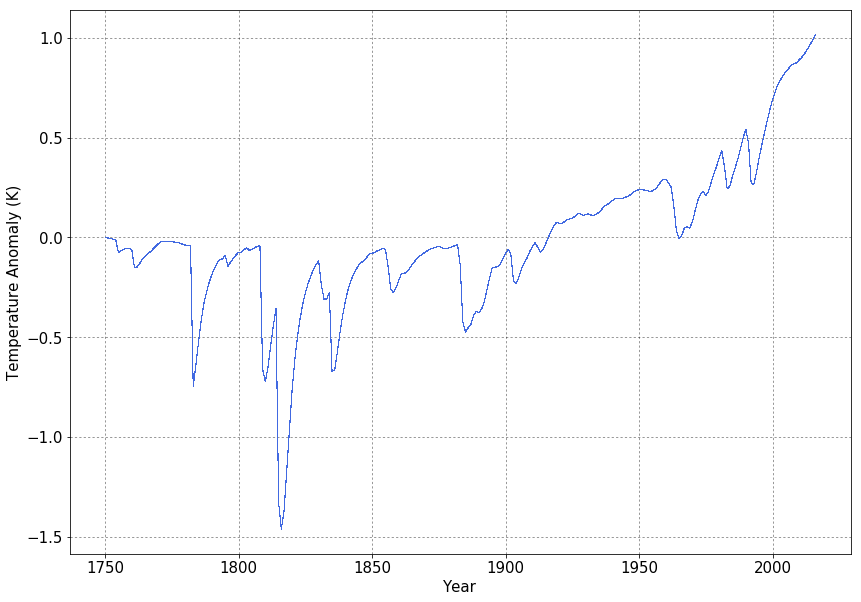

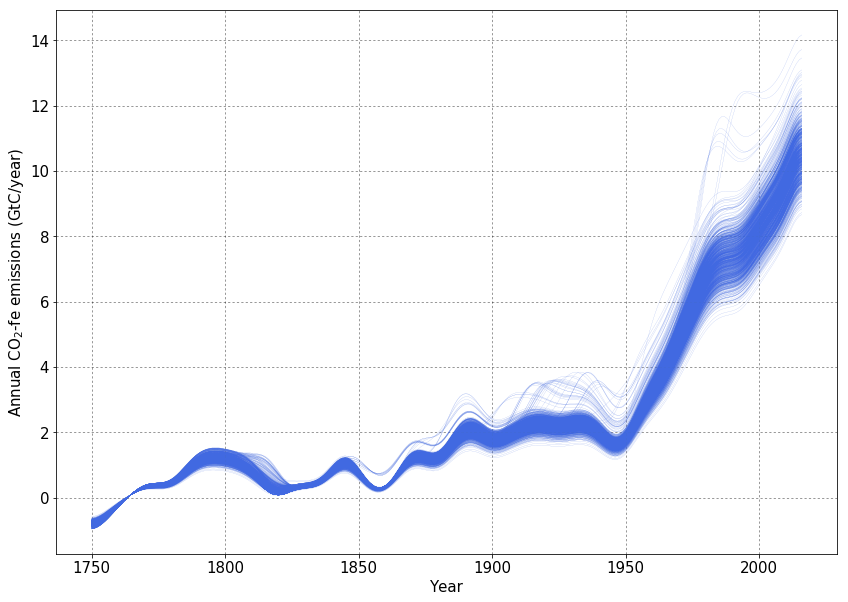

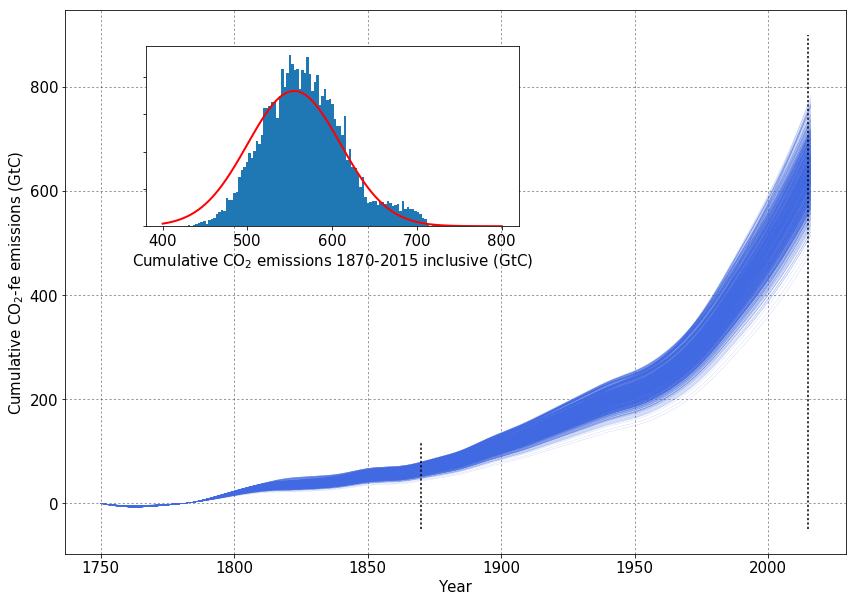

In [167]:
#plot results

for i in range(0, num_params,10):
    plt.plot(np.arange(1750,2017), T_params[0,i,:], color = 'royalblue', linewidth = 0.1)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (K)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)

plt.figure()
for i in range(0, num_params,10):
    plt.plot(np.arange(1750,2017), ems_smooth_params[0,i,:], color = 'royalblue', linewidth = 0.1)
plt.xlabel('Year')
plt.ylabel('Annual CO$_2$-fe emissions (GtC/year)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(0, num_params,10):
    ax1.plot(np.arange(1750,2017), cum_ems_smooth_params[i,:], color = 'royalblue', linewidth = 0.1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Cumulative CO$_2$-fe emissions (GtC)')
ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.plot(np.ones(2)*2015, np.array([-50,900]), color = 'black', linestyle = ':')
ax1.plot(np.ones(2)*1870, np.array([-50,120]), color = 'black', linestyle = ':')

left, bottom, width, height = [0.205, 0.58, 0.37, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist(cum_ems_smooth_params_1870_2015.tolist(), bins = 100, normed = True)
ax2.set_yticklabels([])
ax2.set_xlabel('Cumulative CO$_2$ emissions 1870-2015 inclusive (GtC)')

mu_co2_ems, sigma_co2_ems = 555.0, 55.0
x_co2_ems = np.linspace(400.0, 800.0, 10000)
pdf_co2_ems = np.exp(-(x_co2_ems - mu_co2_ems)**2 / (2 * sigma_co2_ems**2)) / (sigma_co2_ems * np.sqrt(2 * np.pi))
ax2.plot(x_co2_ems, pdf_co2_ems, linewidth=2, color='r')

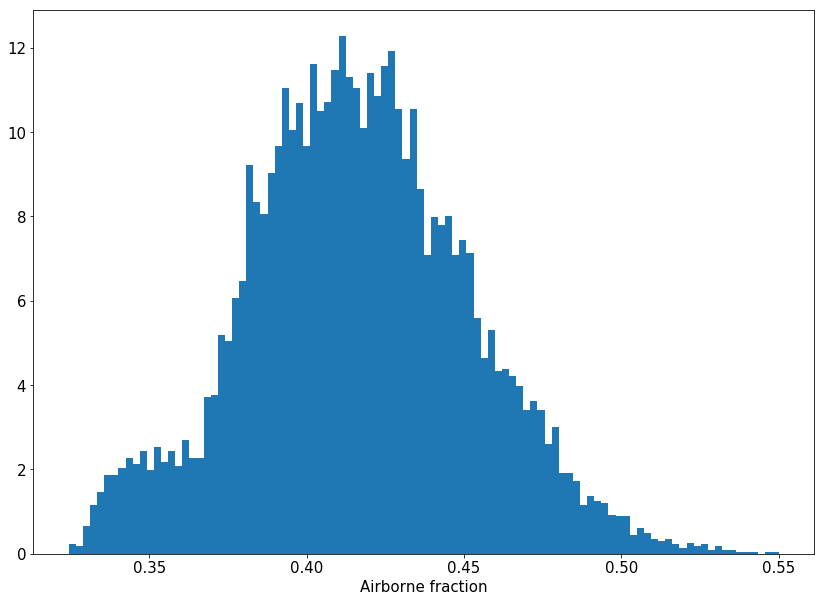

In [168]:
# finding the airborne fraction of emissions:

airborne_fract = 2.123*(C_params[0,:,2015-1750] - C_params[0,:,1870-1750])/cum_ems_smooth_params_1870_2015
f = plt.hist(airborne_fract.tolist(), bins = 100, normed = True)
plt.xlabel('Airborne fraction')

In [169]:
# weighting parameter sets

param_array_weights = np.zeros(num_params)
mu_co2_ems, sigma_co2_ems = 555.0, 55.0
for j in range(0,num_params):
    param_array_weights[j] = np.exp(-(cum_ems_smooth_params[j,265] - mu_co2_ems)**2 / (2 * sigma_co2_ems**2)) / (sigma_co2_ems * np.sqrt(2 * np.pi))

In [170]:
# redo calculation with anthro total emissions

RF_in = rf_comps_median[:,13]
RF_ext = (rf_comps_median[:,13] - rf_comps_median[:,14])

RF_in = RF_in[np.newaxis]
RF_ext = RF_ext[np.newaxis]
    
C_params_total = forcing_to_conc(RF_in, RF_ext = RF_ext, RF_ext_in = True, param_array = param_array_f_to_c)

In [171]:
# find emissions from concentrations and temeprature profiles
    
ems_params_total, ems_smooth_params_total = conc_to_emissions_multiparam(C_params_total, T_params, param_array = param_array_c_to_e)

cum_ems_smooth_params_total = np.cumsum(ems_smooth_params_total[0,:,:], axis = -1)

cum_ems_smooth_params_total_1870_2015 = cum_ems_smooth_params_total[:,2015-1750] - cum_ems_smooth_params_total[:,1870-1750]

#plt.figure()
#f = plt.hist(cum_ems_smooth_params_total[:,1870-1750].tolist(), bins = 100, normed = True)
#(mu_1870_total,sigma_1870_total) = norm.fit(cum_ems_smooth_params_total[:,1870-1750])
#x_1870_total = np.linspace(0, 50, 10000)
#pdf_1870_total = np.exp(-(x_1870_total - mu_1870_total)**2 / (2 * sigma_1870_total**2)) / (sigma_1870_total * np.sqrt(2 * np.pi))
#plt.plot(x_1870_total, pdf_1870_total, linewidth=2, color='r')

#print mu_1870_total, sigma_1870_total

#cum_ems_smooth_params_total = cum_ems_smooth_params_total - mu_1870_total

/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in multiply


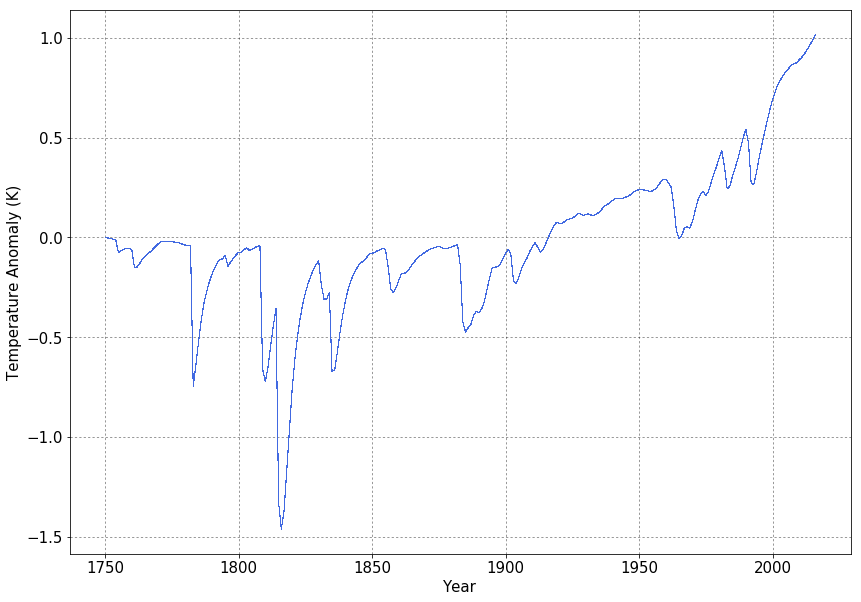

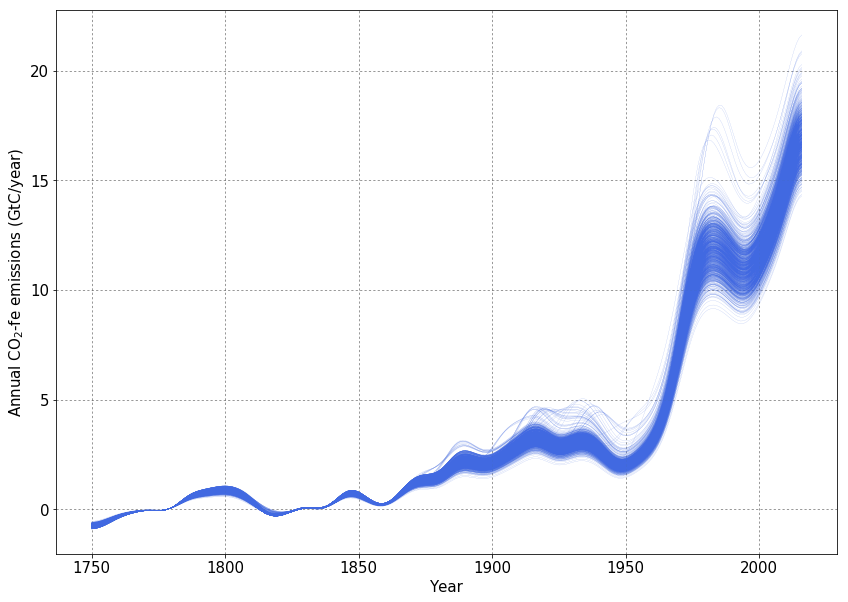

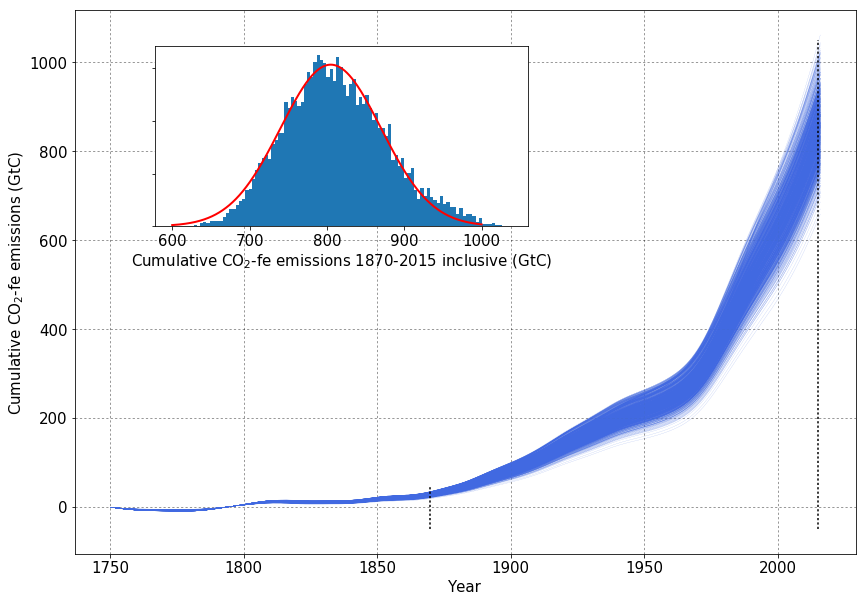

In [188]:
#plot results for anthro_total

for i in range(0, num_params,10):
    plt.plot(np.arange(1750,2017), T_params[0,i,:], color = 'royalblue', linewidth = 0.1)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (K)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)

plt.figure()
for i in range(0, num_params,10):
    plt.plot(np.arange(1750,2017), ems_smooth_params_total[0,i,:], color = 'royalblue', linewidth = 0.1)
plt.xlabel('Year')
plt.ylabel('Annual CO$_2$-fe emissions (GtC/year)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(0, num_params,10):
    ax1.plot(np.arange(1750,2017), cum_ems_smooth_params_total[i,:], color = 'royalblue', linewidth = 0.1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Cumulative CO$_2$-fe emissions (GtC)')
ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.plot(np.ones(2)*2015, np.array([-50,1050]), color = 'black', linestyle = ':')
ax1.plot(np.ones(2)*1870, np.array([-50,50]), color = 'black', linestyle = ':')

left, bottom, width, height = [0.205, 0.58, 0.37, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist(cum_ems_smooth_params_total_1870_2015.tolist(), bins = 100, normed = True)#, weights = param_array_weights)
ax2.set_yticklabels([])
ax2.set_xlabel('Cumulative CO$_2$-fe emissions 1870-2015 inclusive (GtC)')

x_final = np.linspace(600,1000,10000)
mu_final, sigma_final = 805.0, 65.0
pdf_final = np.exp(-(x_final - mu_final)**2 / (2 * sigma_final**2)) / (sigma_final * np.sqrt(2 * np.pi))
ax2.plot(x_final, pdf_final, linewidth = 2, color = 'red')

R_0: 32.989565697, R_C: 0.0223584188309, R_T: 4.90120075951
 plus FAIR STANDARD PARAMETERS


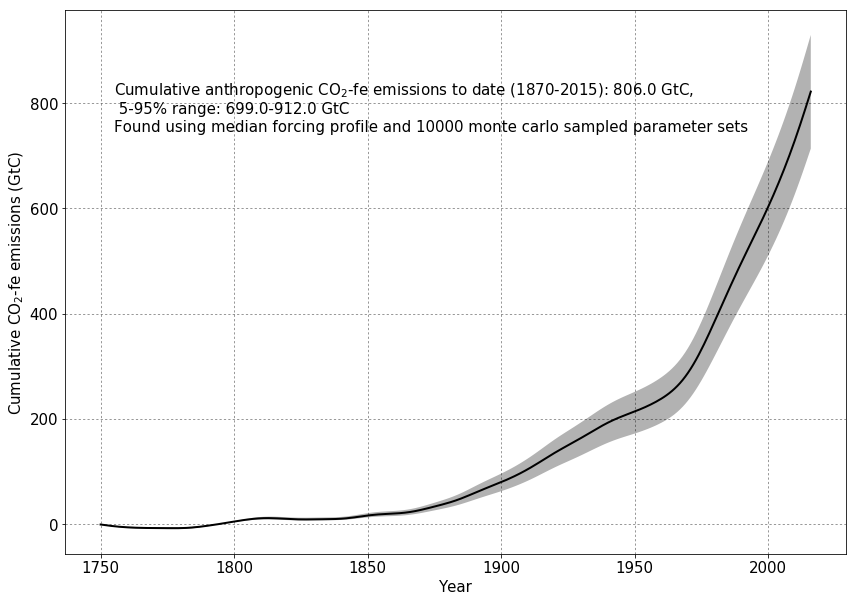

In [190]:
# computing 5 and 95th percentiles for total anthropogenic warming due to parameter set chosen
import scipy

x_95_final = sigma_final*2. + mu_final

x_lower = scipy.special.erfinv(2.*0.95 - 1)*(np.sqrt(2)*sigma_final) + mu_final
x_upper = scipy.special.erfinv(2.*0.05 - 1)*(np.sqrt(2)*sigma_final) + mu_final

# will need to vary these each run to find only one value each time!!! IMPROVE
for i in range(0,num_params):
    if np.abs(cum_ems_smooth_params_total[i,265] - x_lower) < 1.:
        ans_lower = i
    elif np.abs(cum_ems_smooth_params_total[i,265] - x_upper) < 1.:
        ans_upper = i
    elif np.abs(cum_ems_smooth_params_total[i,265] - mu_final) < 1.:
        ans_mu = i

plt.xlabel('Year')
plt.ylabel('Cumulative CO$_2$-fe emissions (GtC)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
#plt.plot(np.ones(2)*2015, np.array([-50,1050]), color = 'red', linestyle = ':')
#plt.plot(np.ones(2)*1870, np.array([-50,50]), color = 'black', linestyle = '-')
        
plt.fill_between(np.arange(1750,2017), cum_ems_smooth_params_total[ans_lower,:], cum_ems_smooth_params_total[ans_upper,:], facecolor='black', alpha = 0.3)
#plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total[ans_lower,:], color = 'red', linewidth = 2)
#plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total[ans_upper,:], color = 'red', linewidth = 2)
plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total[ans_mu,:], color = 'black', linewidth = 2)

plt.text(1755,750, 'Cumulative anthropogenic CO$_2$-fe emissions to date (1870-2015): %s GtC,\n 5-95%% range: %s-%s GtC\nFound using median forcing profile and %s monte carlo sampled parameter sets' %(round(cum_ems_smooth_params_total[ans_mu,265],0), round(cum_ems_smooth_params_total[ans_upper,265],0), round(cum_ems_smooth_params_total[ans_lower,265],0), num_params))   



# print most likely parameter set:
print 'R_0: %s, R_C: %s, R_T: %s\n plus FAIR STANDARD PARAMETERS' %(param_array_c_to_e[ans_mu,9], param_array_c_to_e[ans_mu,10], param_array_c_to_e[ans_mu,11])

#plt.savefig('Cumulative anthro CO2-fe emissions parameter uncertainty analysis')

In [ ]:
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------

In [122]:
import scipy

def RWF_CDF_calc(lower_bound, upper_bound, x_lower, x_upper):
    
    sigma = (x_upper-x_lower)/(np.sqrt(2) * (scipy.special.erf(2*upper_bound -1) - scipy.special.erf(2*lower_bound -1)))
    mu = x_upper - scipy.special.erfinv(2*upper_bound - 1)*np.sqrt(2)*sigma
    
    return mu, sigma

sigmas2 = RWF_CDF_calc(0.05, 0.95, 0.87*32.4, 1.13*32.4)
print sigmas2

#---------

def lognormal_CDF_calc(lower_bound, upper_bound, x_lower, x_upper):
    
    sigma = (np.log(x_upper) - np.log(x_lower))/(np.sqrt(2)*(scipy.special.erfinv(2*upper_bound - 1) - scipy.special.erfinv(2*lower_bound - 1)))
    mu = np.log(x_lower) - np.sqrt(2)*sigma*scipy.special.erfinv(2*lower_bound - 1)
    
    return mu, sigma

sigmas = lognormal_CDF_calc(0.05, 0.95, 1.0, 2.5)
print sigmas

(30.464588020906444, 3.7373611112661744)
(0.45814536593707766, 0.27853260523016377)


In [17]:
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------
#------------------------------------------------------------------------------



#uncertainty due to parameters found with RCP3PD RF dataset

forc_file = './RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)

# we use the co2 only forcing diagnosed in Piers data file to calculate using 1000 randomly sampled parameter sets
C_1, T_params_rcp = FAIR_model(other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'], input_params = input_params)
T_params_rcp = T_params_rcp[np.newaxis]

RF_in_rcp = forc_data['TOTAL_INCLVOLCANIC_RF']
RF_ext_rcp = (forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['CO2_RF'])

RF_in_rcp = RF_in_rcp[np.newaxis]
RF_ext_rcp = RF_ext_rcp[np.newaxis]
    
C_params_rcp = forcing_to_conc(RF_in_rcp, RF_ext = RF_ext_rcp, RF_ext_in = True, param_array = param_array_f_to_c)

# find emissions from concentrations and temeprature profiles
ems_params_rcp, ems_smooth_params_rcp = conc_to_emissions_multiparam(C_params_rcp, T_params_rcp, param_array = param_array_c_to_e)

cum_ems_smooth_params_rcp = np.cumsum(ems_smooth_params_rcp[0,:,:], axis = -1)

---------- Run time was 2 minutes and 40 seconds ----------


/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in multiply


70.2084199899 6.65085240272


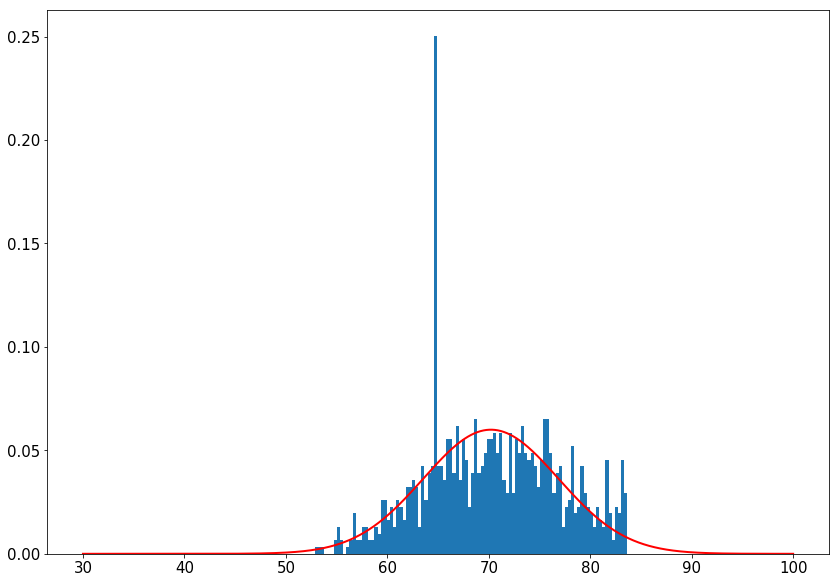

In [18]:
plt.figure()
f = plt.hist(cum_ems_smooth_params_rcp[:,1870-1765].tolist(), bins = 100, normed = True)
(mu_1870_rcp,sigma_1870_rcp) = norm.fit(cum_ems_smooth_params_rcp[:,1870-1765])
x_1870_rcp = np.linspace(30, 100, 10000)
pdf_1870_rcp = np.exp(-(x_1870_rcp - mu_1870_rcp)**2 / (2 * sigma_1870_rcp**2)) / (sigma_1870_rcp * np.sqrt(2 * np.pi))
plt.plot(x_1870_rcp, pdf_1870_rcp, linewidth=2, color='r')

print mu_1870_rcp, sigma_1870_rcp

cum_ems_smooth_params_rcp = cum_ems_smooth_params_rcp - mu_1870_rcp

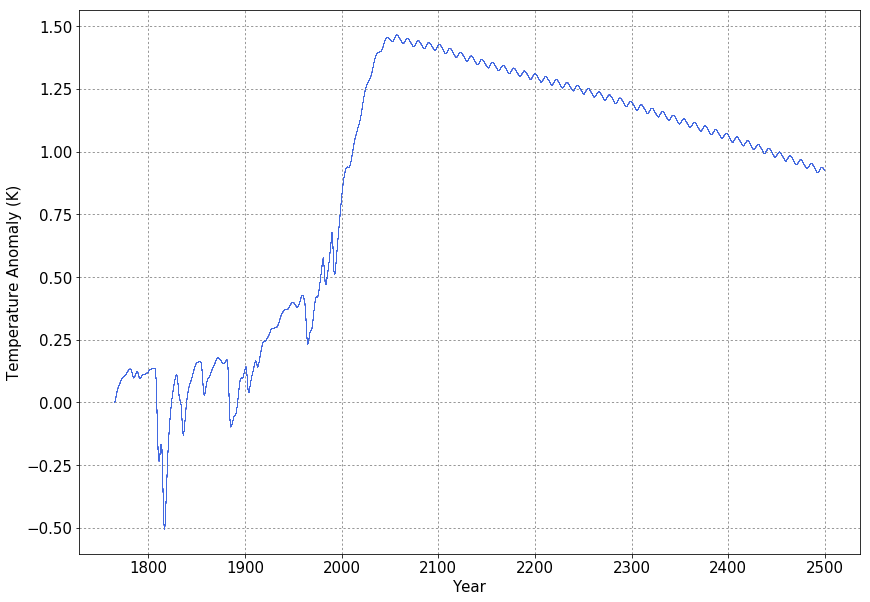

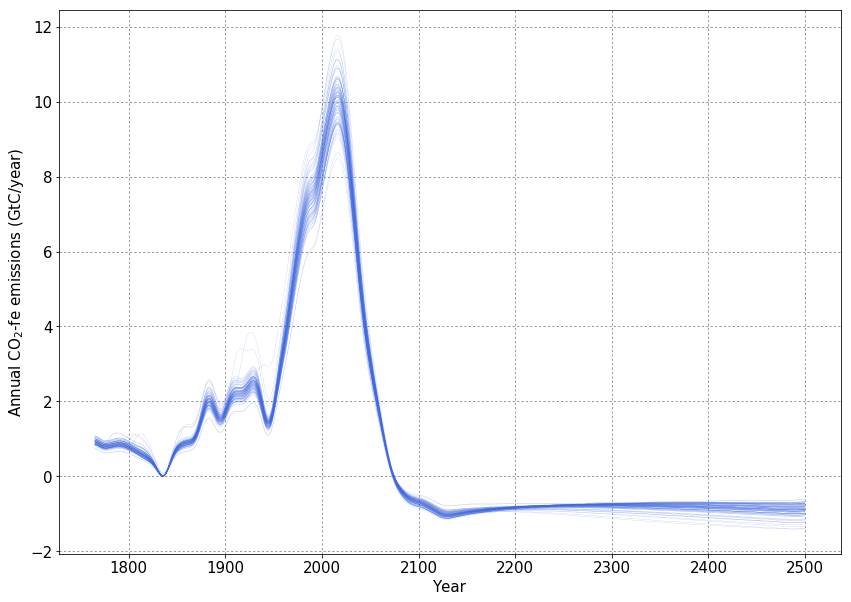

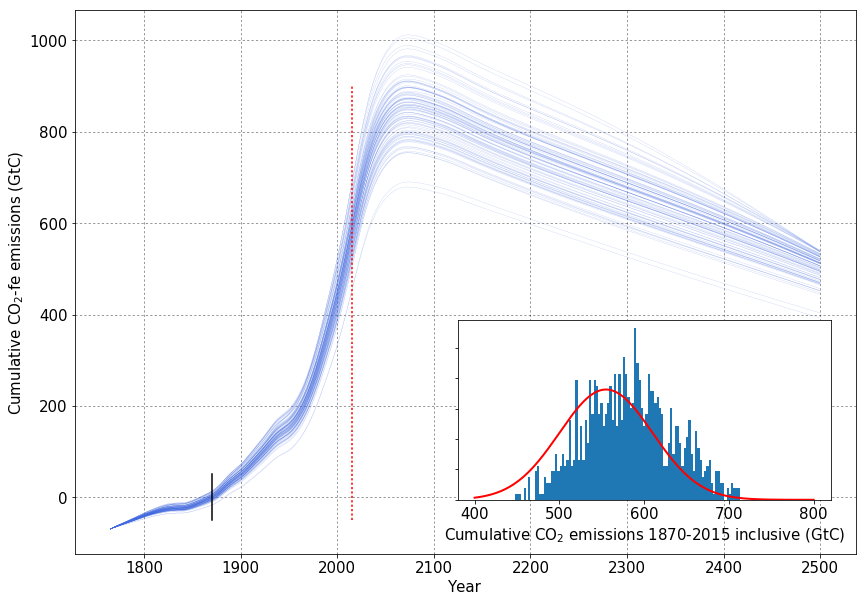

In [19]:
#plot results

for i in range(0, num_params,10):
    plt.plot(np.arange(1765,2501), T_params_rcp[0,i,:], color = 'royalblue', linewidth = 0.1)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (K)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)

plt.figure()
for i in range(0, num_params,10):
    plt.plot(np.arange(1765,2501), ems_smooth_params_rcp[0,i,:], color = 'royalblue', linewidth = 0.1)
plt.xlabel('Year')
plt.ylabel('Annual CO$_2$-fe emissions (GtC/year)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(0, num_params,10):
    ax1.plot(np.arange(1765,2501), cum_ems_smooth_params_rcp[i,:], color = 'royalblue', linewidth = 0.1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Cumulative CO$_2$-fe emissions (GtC)')
ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.plot(np.ones(2)*2015, np.array([-50,900]), color = 'red', linestyle = ':')
ax1.plot(np.ones(2)*1870, np.array([-50,50]), color = 'black', linestyle = '-')

left, bottom, width, height = [0.505, 0.2, 0.37, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist(cum_ems_smooth_params_rcp[:,2015-1765].tolist(), bins = 100, normed = True)
ax2.set_yticklabels([])
ax2.set_xlabel('Cumulative CO$_2$ emissions 1870-2015 inclusive (GtC)')

mu_co2_ems, sigma_co2_ems = 555.0, 55.0
x_co2_ems = np.linspace(400.0, 800.0, 10000)
pdf_co2_ems = np.exp(-(x_co2_ems - mu_co2_ems)**2 / (2 * sigma_co2_ems**2)) / (sigma_co2_ems * np.sqrt(2 * np.pi))
ax2.plot(x_co2_ems, pdf_co2_ems, linewidth=2, color='r')

In [20]:
param_array_weights_rcp = np.zeros(num_params)
mu_co2_ems, sigma_co2_ems = 555.0, 55.0
for j in range(0,num_params):
    param_array_weights_rcp[j] = np.exp(-(cum_ems_smooth_params_rcp[j,265] - mu_co2_ems)**2 / (2 * sigma_co2_ems**2)) / (sigma_co2_ems * np.sqrt(2 * np.pi))

/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/Users/Stuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in multiply


65.7305986231 6.35787347446


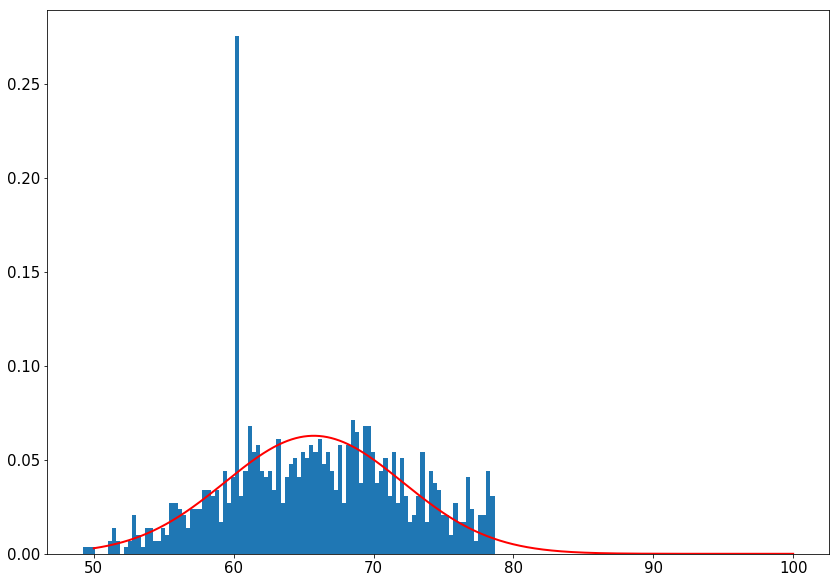

In [44]:
# redo calculation with anthro total emissions

RF_in_rcp1 = forc_data['TOTAL_INCLVOLCANIC_RF']
RF_ext_rcp1 = (forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['TOTAL_ANTHRO_RF'])

RF_in_rcp1 = RF_in_rcp1[np.newaxis]
RF_ext_rcp1 = RF_ext_rcp1[np.newaxis]
    
C_params_total_rcp = forcing_to_conc(RF_in_rcp1, RF_ext = RF_ext_rcp1, RF_ext_in = True, param_array = param_array_f_to_c)

# find emissions from concentrations and temeprature profiles
    
ems_params_total_rcp, ems_smooth_params_total_rcp = conc_to_emissions_multiparam(C_params_total_rcp, T_params_rcp, param_array = param_array_c_to_e)

cum_ems_smooth_params_total_rcp = np.cumsum(ems_smooth_params_total_rcp[0,:,:], axis = -1)

plt.figure()
f = plt.hist(cum_ems_smooth_params_total_rcp[:,1870-1765].tolist(), bins = 100, normed = True)
(mu_1870_total_rcp,sigma_1870_total_rcp) = norm.fit(cum_ems_smooth_params_total_rcp[:,1870-1765])
x_1870_total_rcp = np.linspace(50, 100, 10000)
pdf_1870_total_rcp = np.exp(-(x_1870_total_rcp - mu_1870_total_rcp)**2 / (2 * sigma_1870_total_rcp**2)) / (sigma_1870_total_rcp * np.sqrt(2 * np.pi))
plt.plot(x_1870_total_rcp, pdf_1870_total_rcp, linewidth=2, color='r')

print mu_1870_total_rcp, sigma_1870_total_rcp

cum_ems_smooth_params_total_rcp = cum_ems_smooth_params_total_rcp - mu_1870_total_rcp

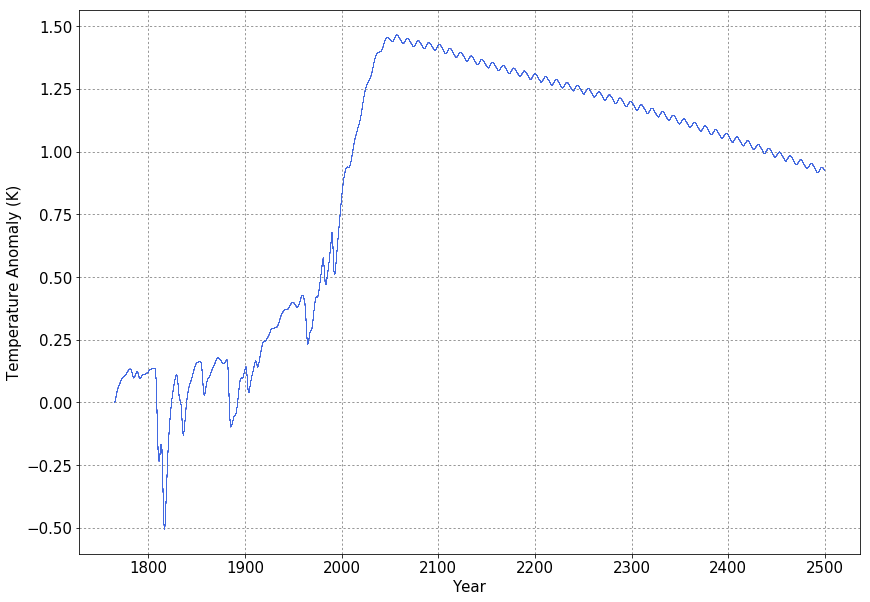

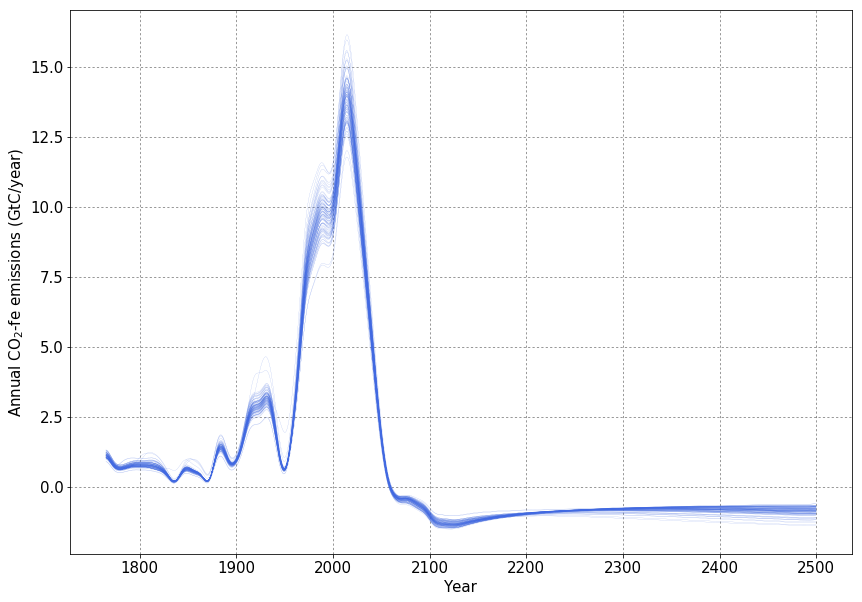

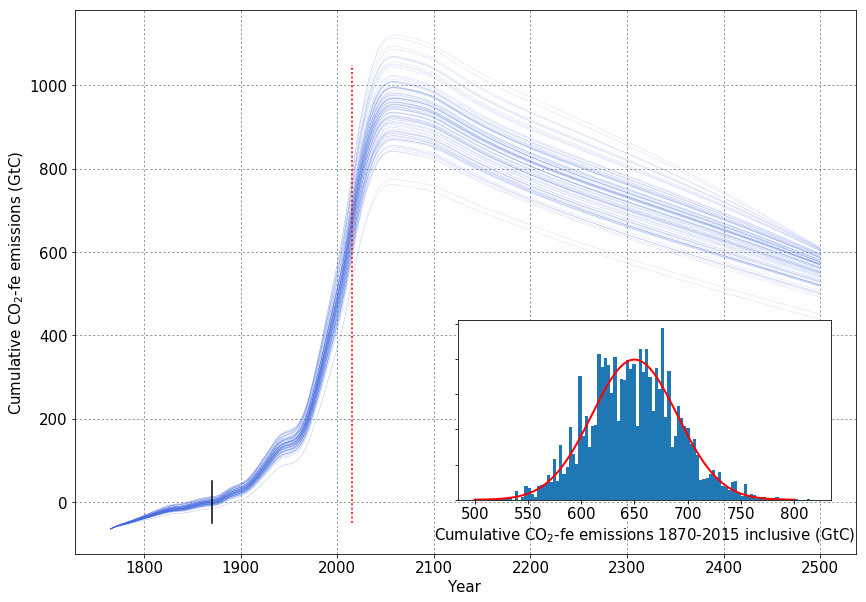

In [46]:
#plot results for anthro_total RCP3PD

for i in range(0, num_params,10):
    plt.plot(np.arange(1765,2501), T_params_rcp[0,i,:], color = 'royalblue', linewidth = 0.1)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (K)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)

plt.figure()
for i in range(0, num_params,10):
    plt.plot(np.arange(1765,2501), ems_smooth_params_total_rcp[0,i,:], color = 'royalblue', linewidth = 0.1)
plt.xlabel('Year')
plt.ylabel('Annual CO$_2$-fe emissions (GtC/year)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(0, num_params,10):
    ax1.plot(np.arange(1765,2501), cum_ems_smooth_params_total_rcp[i,:], color = 'royalblue', linewidth = 0.1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Cumulative CO$_2$-fe emissions (GtC)')
ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.plot(np.ones(2)*2015, np.array([-50,1050]), color = 'red', linestyle = ':')
ax1.plot(np.ones(2)*1870, np.array([-50,50]), color = 'black', linestyle = '-')

left, bottom, width, height = [0.505, 0.2, 0.37, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist(cum_ems_smooth_params_total_rcp[:,2015-1765].tolist(), bins = 100, normed = True, weights = param_array_weights)
ax2.set_yticklabels([])
ax2.set_xlabel('Cumulative CO$_2$-fe emissions 1870-2015 inclusive (GtC)')

x_final_rcp = np.linspace(500,800,10000)
mu_final_rcp, sigma_final_rcp = 650.0, 40.0
pdf_final_rcp = np.exp(-(x_final_rcp - mu_final_rcp)**2 / (2 * sigma_final_rcp**2)) / (sigma_final_rcp * np.sqrt(2 * np.pi))
ax2.plot(x_final_rcp, pdf_final_rcp, linewidth = 2, color = 'red')

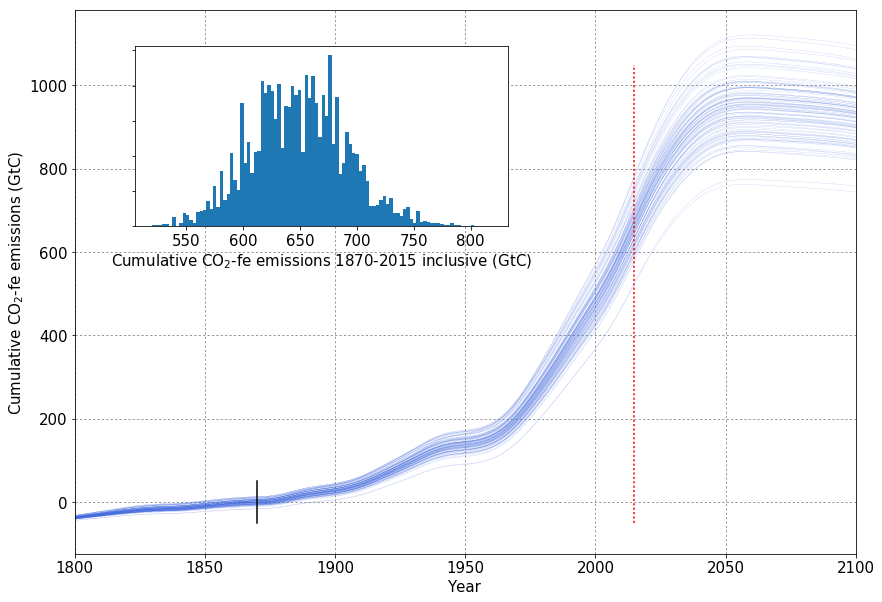

In [50]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(0, num_params,10):
    ax1.plot(np.arange(1765,2501), cum_ems_smooth_params_total_rcp[i,:], color = 'royalblue', linewidth = 0.1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Cumulative CO$_2$-fe emissions (GtC)')
ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.plot(np.ones(2)*2015, np.array([-50,1050]), color = 'red', linestyle = ':')
ax1.plot(np.ones(2)*1870, np.array([-50,50]), color = 'black', linestyle = '-')
ax1.set_xlim(1800,2100)

left, bottom, width, height = [0.185, 0.58, 0.37, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.hist(cum_ems_smooth_params_total_rcp[:,2015-1765].tolist(), bins = 100, normed = True, weights = param_array_weights)
ax2.set_yticklabels([])
ax2.set_xlabel('Cumulative CO$_2$-fe emissions 1870-2015 inclusive (GtC)')

R_0: 31.3599443986, R_C: 0.0199033475647, R_T: 4.36302329511
 plus FAIR STANDARD PARAMETERS


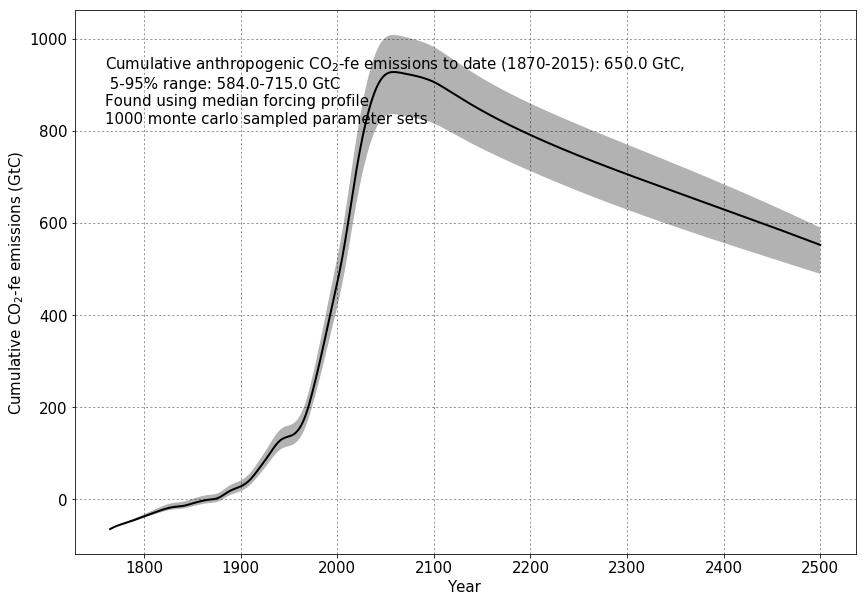

In [71]:
# computing 5 and 95th percentiles for total anthropogenic warming due to parameter set chosen
import scipy

x_95_final_rcp = sigma_final_rcp*2. + mu_final_rcp

x_lower_rcp = scipy.special.erfinv(2.*0.95 - 1)*(np.sqrt(2)*sigma_final_rcp) + mu_final_rcp
x_upper_rcp = scipy.special.erfinv(2.*0.05 - 1)*(np.sqrt(2)*sigma_final_rcp) + mu_final_rcp

# will need to vary these each run to find only one value each time!!! IMPROVE
for i in range(0,num_params):
    if np.abs(cum_ems_smooth_params_total_rcp[i,2015-1765] - x_lower_rcp) < 1.:
        ans_lower_rcp = i
    elif np.abs(cum_ems_smooth_params_total_rcp[i,2015-1765] - x_upper_rcp) < 1.:
        ans_upper_rcp = i
    elif np.abs(cum_ems_smooth_params_total_rcp[i,2015-1765] - mu_final_rcp) < 1.:
        ans_mu_rcp = i

plt.xlabel('Year')
plt.ylabel('Cumulative CO$_2$-fe emissions (GtC)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
#plt.plot(np.ones(2)*2015, np.array([-50,1050]), color = 'red', linestyle = ':')
#plt.plot(np.ones(2)*1870, np.array([-50,50]), color = 'black', linestyle = '-')
        
plt.fill_between(np.arange(1765,2501), cum_ems_smooth_params_total_rcp[ans_lower_rcp,:], cum_ems_smooth_params_total_rcp[ans_upper_rcp,:], facecolor='black', alpha = 0.3)
#plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total_rcp[ans_lower_rcp,:], color = 'red', linewidth = 2)
#plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total_rcp[ans_upper_rcp,:], color = 'red', linewidth = 2)
plt.plot(np.arange(1765,2501), cum_ems_smooth_params_total_rcp[ans_mu_rcp,:], color = 'black', linewidth = 2)
#plt.xlim(1750,2020)
plt.text(1760,820, 'Cumulative anthropogenic CO$_2$-fe emissions to date (1870-2015): %s GtC,\n 5-95%% range: %s-%s GtC\nFound using median forcing profile\n%s monte carlo sampled parameter sets' %(round(cum_ems_smooth_params_total_rcp[ans_mu_rcp,2015-1765],0), round(cum_ems_smooth_params_total_rcp[ans_upper_rcp,2015-1765],0), round(cum_ems_smooth_params_total_rcp[ans_lower_rcp,2015-1765],0), num_params))   



# print most likely parameter set:
print 'R_0: %s, R_C: %s, R_T: %s\n plus FAIR STANDARD PARAMETERS' %(param_array_c_to_e[ans_mu_rcp,9], param_array_c_to_e[ans_mu_rcp,10], param_array_c_to_e[ans_mu_rcp,11])

#plt.savefig('Cumulative anthro CO2-fe emissions parameter uncertainty analysis')

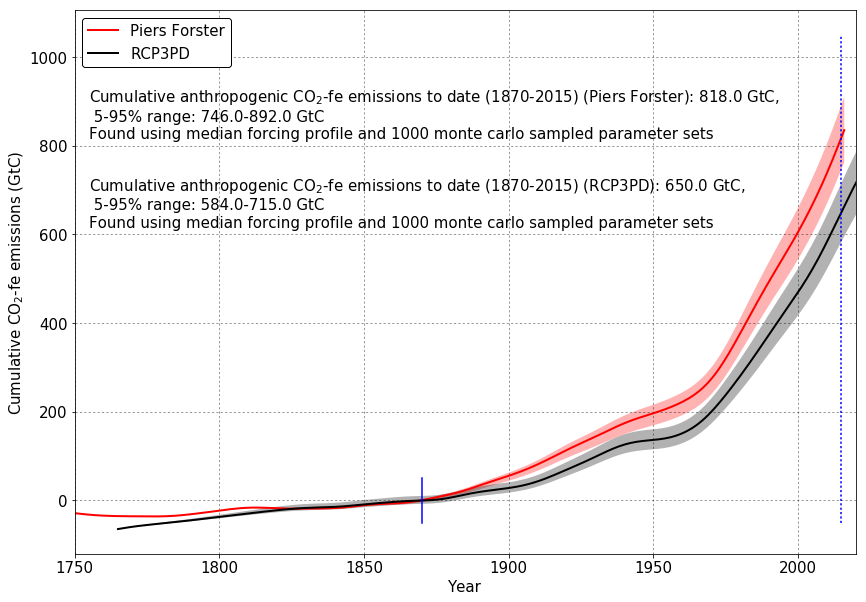

In [68]:
plt.xlabel('Year')
plt.ylabel('Cumulative CO$_2$-fe emissions (GtC)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
#plt.plot(np.ones(2)*2015, np.array([-50,1050]), color = 'red', linestyle = ':')
#plt.plot(np.ones(2)*1870, np.array([-50,50]), color = 'black', linestyle = '-')
        
plt.fill_between(np.arange(1750,2017), cum_ems_smooth_params_total[ans_lower,:], cum_ems_smooth_params_total[ans_upper,:], facecolor='red', alpha = 0.3)
#plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total[ans_lower,:], color = 'red', linewidth = 2)
#plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total[ans_upper,:], color = 'red', linewidth = 2)
plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total[ans_mu,:], color = 'red', linewidth = 2, label = 'Piers Forster')

plt.text(1755,820, 'Cumulative anthropogenic CO$_2$-fe emissions to date (1870-2015) (Piers Forster): %s GtC,\n 5-95%% range: %s-%s GtC\nFound using median forcing profile and %s monte carlo sampled parameter sets' %(round(cum_ems_smooth_params_total[ans_mu,265],0), round(cum_ems_smooth_params_total[ans_upper,265],0), round(cum_ems_smooth_params_total[ans_lower,265],0), num_params))   

#---------

plt.fill_between(np.arange(1765,2501), cum_ems_smooth_params_total_rcp[ans_lower_rcp,:], cum_ems_smooth_params_total_rcp[ans_upper_rcp,:], facecolor='black', alpha = 0.3)
#plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total_rcp[ans_lower_rcp,:], color = 'red', linewidth = 2)
#plt.plot(np.arange(1750,2017), cum_ems_smooth_params_total_rcp[ans_upper_rcp,:], color = 'red', linewidth = 2)
plt.plot(np.arange(1765,2501), cum_ems_smooth_params_total_rcp[ans_mu_rcp,:], color = 'black', linewidth = 2, label = 'RCP3PD')
plt.xlim(1750,2020)
plt.legend(loc = 'best', framealpha = 1, edgecolor = 'black')
plt.text(1755,620, 'Cumulative anthropogenic CO$_2$-fe emissions to date (1870-2015) (RCP3PD): %s GtC,\n 5-95%% range: %s-%s GtC\nFound using median forcing profile and %s monte carlo sampled parameter sets' %(round(cum_ems_smooth_params_total_rcp[ans_mu_rcp,2015-1765],0), round(cum_ems_smooth_params_total_rcp[ans_upper_rcp,2015-1765],0), round(cum_ems_smooth_params_total_rcp[ans_lower_rcp,2015-1765],0), num_params))   

plt.plot(np.ones(2)*2015, np.array([-50,1050]), color = 'blue', linestyle = ':')
plt.plot(np.ones(2)*1870, np.array([-50,50]), color = 'blue', linestyle = '-')